<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2019

# 1. Data cleaning, normalisation and quality assurance

This notebook describes raw data import, cleaning, and QA, then writing out of processed data to the `data/` subdirectory, for use in model fitting.

## Table of Contents

 1. [Microarray data](#microarray_data)
    1. [Import array data](#import_data)
 2. [Data QA](#data_qa)
    1. [Problematic probes](#problem_probes)
    2. [Interpolation for problematic probes](#interpolation)    
 3. [Normalisation](#normalisation)
 4. [Wide to long form](#wide_to_long)
 5. [Probe matches to Sakai and DH10B](#probe_matches)
 6. [Write data](#write)

## Python imports

In [1]:
%pylab inline

import os
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from Bio import SeqIO

import tools

Populating the interactive namespace from numpy and matplotlib


## Microarray data <a id="microarray_data"></a>

<div class="alert alert-warning">
Raw array data was previously converted to plain text comma-separated variable format from two `Excel` files:

<ul>
<li> The file `AH alldata 12082013.xlsx` was converted to `data/treatment_unix_endings.csv`
<li> The file `AH alldata expt1 flagged 05092013.xlsx` was converted to `data/control_unix_endings_flags.csv`
</ul>
</div>

These describe microarray results for samples that underwent two treatments:

* *in vitro* growth only - i.e. **control**: `data/control_unix_endings_flags.csv`
* *in vitro* growth and plant passage - i.e. **treatment**: `data/treatment_unix_endings.csv`

In [2]:
# Input array data filepaths
controlarrayfile = os.path.join('..', 'data', 'control_unix_endings_flags.csv')  # control experiment array data (preprocessed)
treatmentarrayfile = os.path.join('..', 'data', 'treatment_unix_endings.csv')     # treatment experiment array data (preprocessed)

### Import array data <a id="import_data"></a>

In [3]:
control = pd.read_csv(controlarrayfile, sep=',', skiprows=4, index_col=0)
treatment = pd.read_csv(treatmentarrayfile, sep=',', skiprows=4, index_col=0)

# Uncomment the lines below to inspect the first few rows of each dataframe
#control.head()
#treatment.head()

In [4]:
len(control)

10751

<div class="alert alert-warning">
We reduce the full dataset to only the raw intensity values. We also rename the columns in each of the `control` and `treatment` dataframes. 
</div>

In both *control* and *treatment* datasets, the mapping of experimental samples (*input* and *output*) across the three replicates is:

* replicate 1 *input*: `Raw` $\rightarrow$ `input.1`
* replicate 1 *output*: `Raw.1` $\rightarrow$ `output.1`
* replicate 2 *input*: `Raw.2` $\rightarrow$ `input.2`
* replicate 2 *output*: `Raw.3` $\rightarrow$ `output.2`
* replicate 3 *input*: `Raw.4` $\rightarrow$ `input.3`
* replicate 3 *output*: `Raw.5` $\rightarrow$ `output.3`

In [5]:
colnames_in = ['Raw', 'Raw.1', 'Raw.2', 'Raw.3', 'Raw.4', 'Raw.5']  # raw data columns
colnames_out = ['input.1', 'output.1', 'input.2', 'output.2', 'input.3', 'output.3']  # renamed raw data columns

# Reduce control and treatment arrays to raw data columns only
control = control[colnames_in]
control.columns = colnames_out
treatment = treatment[colnames_in]
treatment.columns = colnames_out

## Data QA <a id="data_qa"></a>

We expect that there is good agreement between input and output raw intensities for each replicate control or treatment experiment. We also expect that there should be good agreement across replicates within the controls, and within the treatment. We inspect this agreement visually with a matrix of scatterplots, below.

The `plot_correlation()` function can be found in the accompanying `tools.py` module.

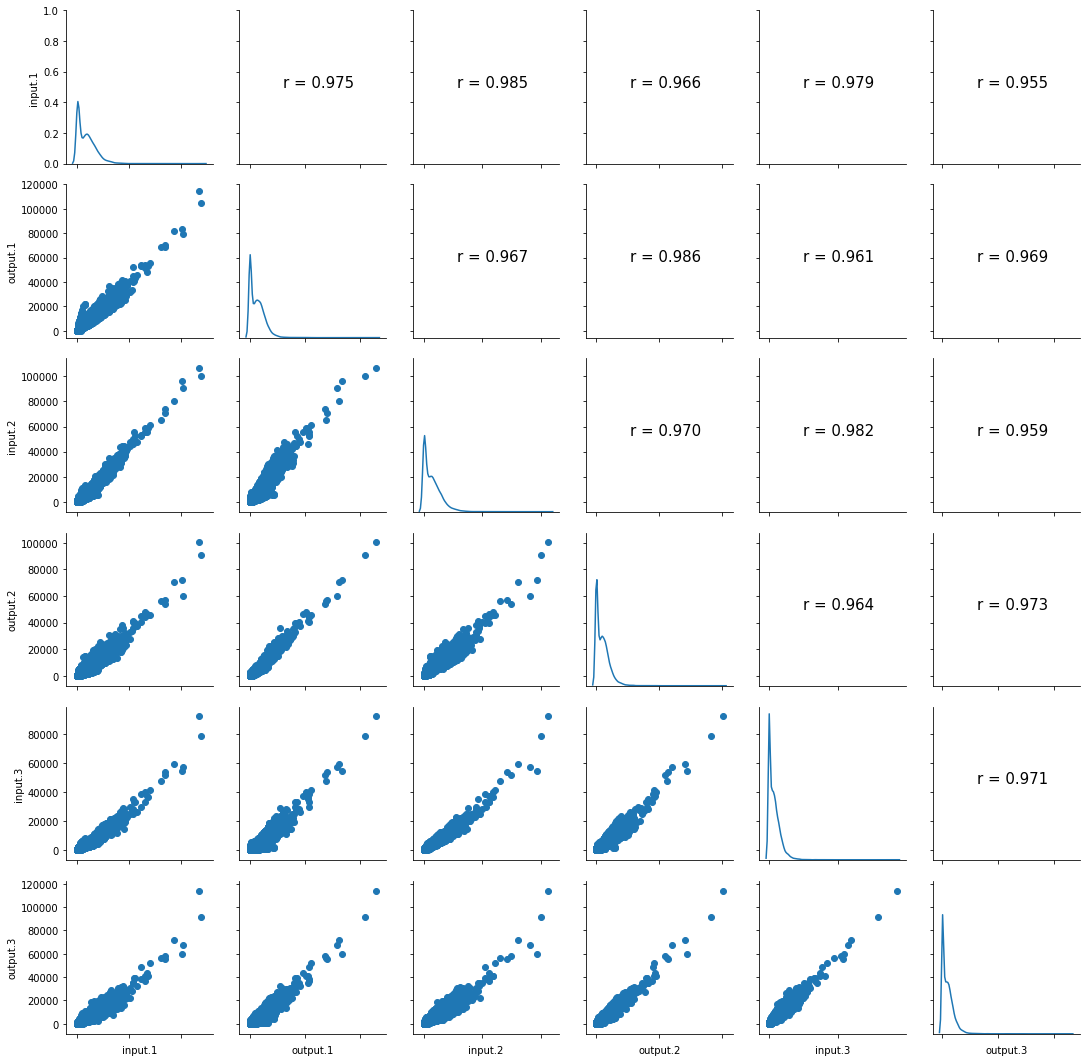

In [6]:
# Plot correlations for control data
tools.plot_correlation(control);

There is good visual correlation between the intensities for the control arrays, and the Spearman's R values also indicate good correlation.

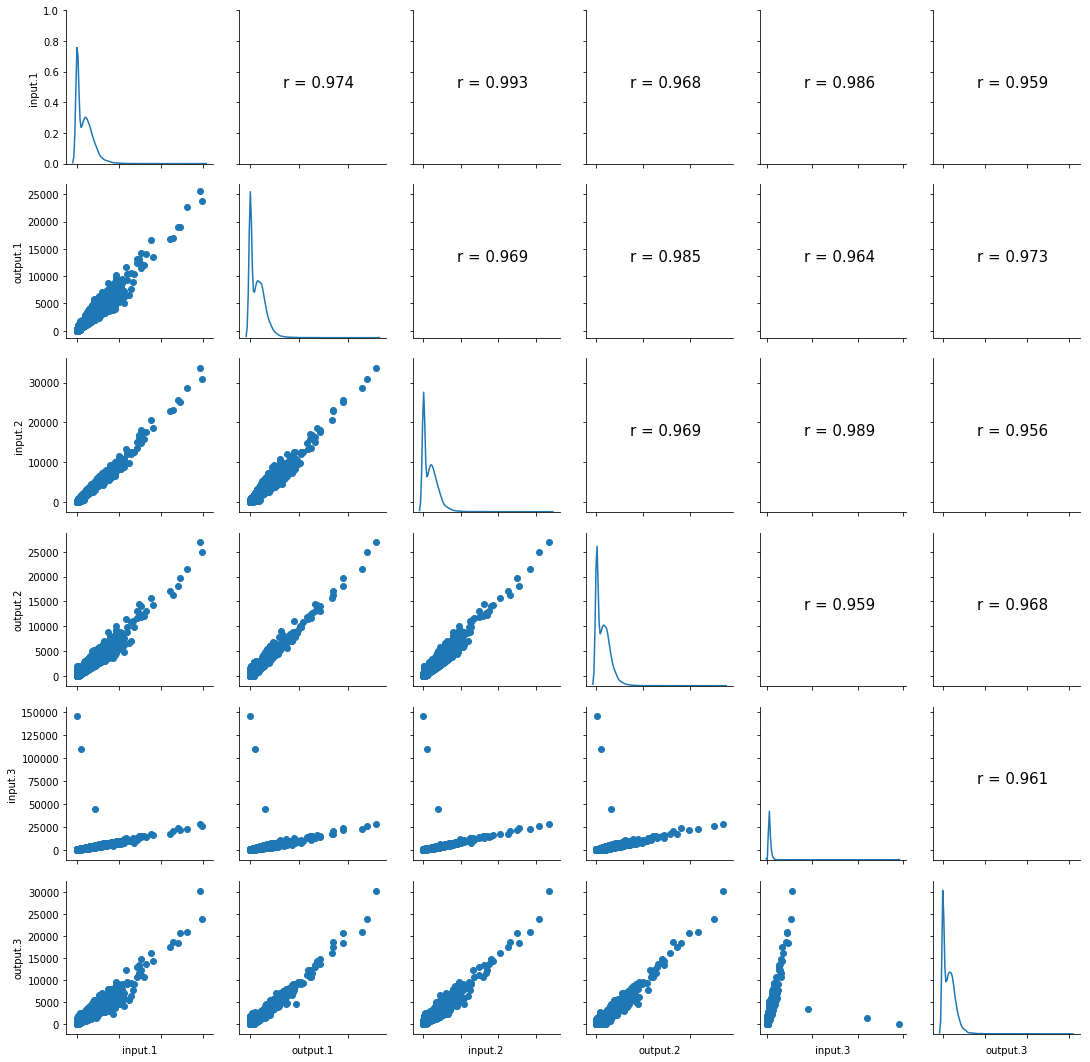

In [7]:
# Plot correlations for treatment data
tools.plot_correlation(treatment);

There is - mostly - good visual correlation between the intensities for the control arrays, and the Spearman's R values also indicate good correlation. There appear to be three problematic probes in replicate 3 that we may need to deal with in the data cleanup.

<div class="alert alert-success">
<b>Taken together, these plots indicate:</b>
<ul>
<li> the intensities of the control arrays are systematically larger than intensities for the treatment arrays, suggesting that the effects of noise may be proportionally greater for the treatment arrays. This might be a concern for reliably inferring enrichment or depletion in the treatment.
<li> the control arrays are good candidates for quantile normalisation (QN; $r > 0.95$, with similar density distributions)
<li> the treatment array `input.3` dataset is potentially problematic, due to three treatment probe datapoints with intensities greater than 40,000 units having large leverage.
</ul>
</div>

### Problematic probes <a id="problem_probes"></a>

<div class="alert-warning">
We can readily identify problematic probes in treatment replicate 3, as they are the only probes with intensity greater than 40,000.

The problematic probes are:
<ul>
    <li> <code>A_07_P000070</code>
    <li> <code>A_07_P061472</code>
    <li> <code>A_07_P052489</code>
</ul>
</div>

In [8]:
# Select outlying treatment input.3 values
treatment.loc[treatment['input.3'] > 4e4]

,input.1,output.1,input.2,output.2,input.3,output.3
Systematic,,,,,,
A_07_P000070,4251.70600,3054.75400,3997.707000,3013.079000,44857.48,3283.400000
A_07_P061472,10.65405,4.49928,1.687277,3.855374,145625.60,8.290274
A_07_P052489,929.70990,1056.72400,987.524200,957.422400,110306.40,1327.634000


In [9]:
# Define problem probes:
problem_probes = list(treatment.loc[treatment['input.3'] > 4e4].index)

### Interpolating values for problem probes <a id="interpolation"></a>

We replace the three clear outlying values for the three problematic probes in `input.3` of the `treatment` array with interpolated values. We assume that `input.1` and `input.2` are typical of the input intensities for these three probes, and take the average of their values to substitute for `input.3` for each.

In [10]:
# Interpolate values 
treatment.set_value(index=problem_probes, col='input.3',
                    value=treatment.loc[problem_probes][['input.1', 'input.2']].mean(1))
treatment.loc[problem_probes]

,input.1,output.1,input.2,output.2,input.3,output.3
Systematic,,,,,,
A_07_P000070,4251.70600,3054.75400,3997.707000,3013.079000,4124.706500,3283.400000
A_07_P061472,10.65405,4.49928,1.687277,3.855374,6.170663,8.290274
A_07_P052489,929.70990,1056.72400,987.524200,957.422400,958.617050,1327.634000


We can visualise the change in correlation for the `treatment` dataframe that results:

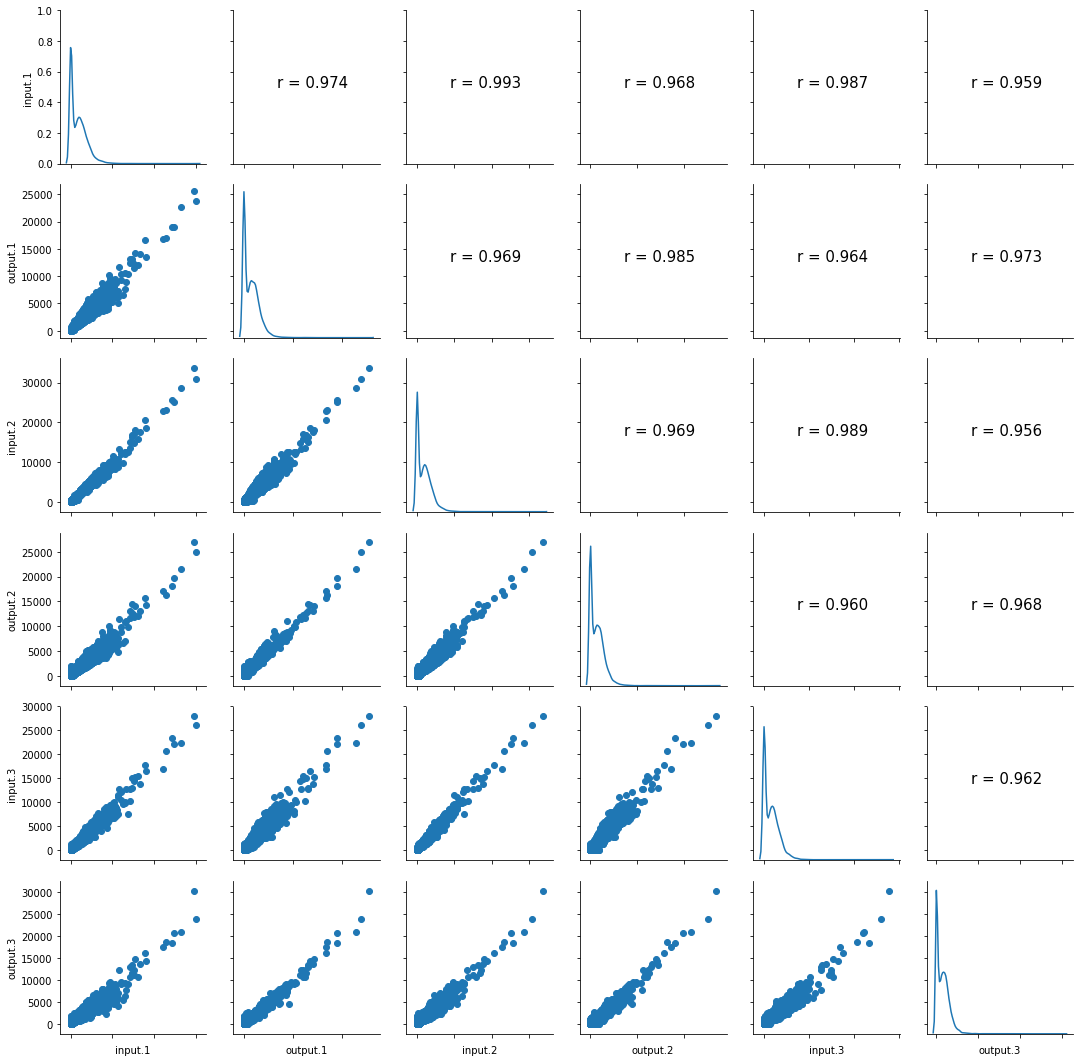

In [11]:
# Plot correlations for treatment data
tools.plot_correlation(treatment);

## Normalisation <a id="normalisation"></a>

We expect the array intensity distribution to vary according to whether the sample was from the input (strong) or output (weak) set, and whether the sample came from the control or treatment pools. We therefore divide the dataset into four independently-normalised components:

* `control_input`
* `control_output`
* `treatment_input`
* `treatment_output`

<br /><div class="alert-success">
We have established that because the input and output arrays in both control and treatment conditions have strong correlation across all intensities, and have similar intensity distributions, we are justified in using quantile (mean) normalisation.
</div>

In [12]:
input_cols = ['input.1', 'input.2', 'input.3']      # input columns
output_cols = ['output.1', 'output.2', 'output.3']  # output columns

# Normalise inputs and outputs for control and treatment separately
control_input = tools.quantile_norm(control, columns=input_cols)
control_output = tools.quantile_norm(control, columns=output_cols)
treatment_input = tools.quantile_norm(treatment, columns=input_cols)
treatment_output = tools.quantile_norm(treatment, columns=output_cols)

We visualise the resulting distributions, in violin plots:

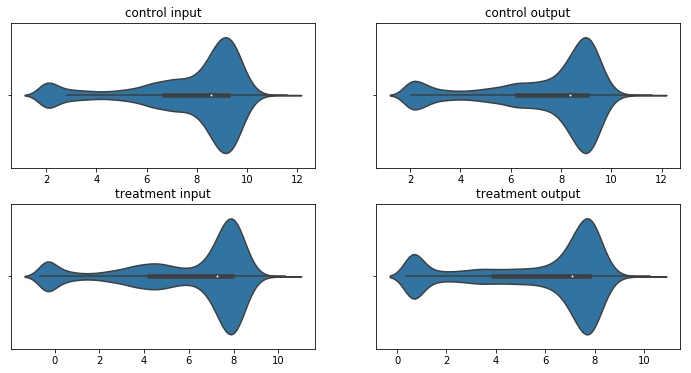

In [13]:
# Make violinplots of normalised data  
tools.plot_normalised(control_input, control_output,
                      treatment_input, treatment_output)

<div class="alert-success">
These plots illustrate that there is relative reduction in measured array intensity between control and treatment arrays for both the input and output arrays.
</div>

## Wide to long form <a id="wide_to_long"></a>

We have four dataframes containing normalised data:

* `control_input`
* `control_output`
* `treatment_input`
* `treatment_output`

Each dataframe is indexed by the array probe systematic name, with three columns that correspond to replicates 1, 2, and 3 for either a control or a treatment run. For downstream analysis we want to organise this data as the following columns:

* `index`: unique ID
* `probe`: probe name (these apply across treatment/control and input/output)
* `input`: normalised input intensity value (for a particular probe and replicate)
* `output`: normalised input intensity value (for a particular probe and replicate)
* `treatment`: 0/1 indicating whether the measurement was made for the control or treatment sample
* `replicate`: 1, 2, 3 indicating which replicate the measurement was made from

<br /><div class="alert-warning">
We will add other columns with relevant data later, and to enable this, we convert the `control` and `treatment` data frames from wide (e.g. `input.1`, `input.2`, `input.3` columns) to long (e.g. `probe`, `input`, `output`, `replicate`) form - once for the control data, and once for the treatment data. We match on a multi-index of probe and replicate.
</div>

In [14]:
# Convert data from wide to long form
data = tools.wide_to_long(control_input, control_output,
                          treatment_input, treatment_output)
data.head()

,probe,replicate,treatment,repXtrt,input,output,log_input,log_output
0,A_07_P010355,1,0,rep1trt0,10.049401,5.969886,2.307513,1.786728
1,A_07_P039196,1,0,rep1trt0,7.638637,7.230899,2.033219,1.978363
2,A_07_P039195,1,0,rep1trt0,14.394261,15.832703,2.666830,2.762078
3,A_07_P039186,1,0,rep1trt0,7.872936,18.637283,2.063431,2.925164
4,A_07_P039181,1,0,rep1trt0,10.100042,7.566543,2.312540,2.023736


Long form data has some advantages for melting into new arrangments for visualisation, analysis, and incorporation of new data. For instance, we can visualise the distributions of input and output log intensities against each other, as below:

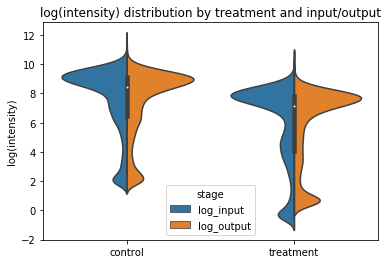

In [15]:
# Visualise input v output distributions
tools.plot_input_output_violin(data)

<div class="alert-success">
This visualisation again shows that treatment intensities are generally lower than control intensities, but also suggests that the bulk of output intensities are lower than input intensities.
<br /><br />
There is a population of low-intensity values for each set of arrays, however. These appear to have a slight increase in intensity in the output, compared to input arrays.
</div>

## Probe matches to Sakai and DH10B <a id="probe_matches"></a>

<div class="alert-warning">
Evidence for potential hybridisation of probes to DH10B or Sakai isolates was determined by default `BLASTN` query of each probe sequence against chromosome and plasmid feature nucleotide sequences from the NCBI records:

<ul>
<li> `GCF_000019425.1_ASM1942v1_cds_from_genomic.fna`
<li> `GCF_000008865.1_ASM886v1_cds_from_genomic.fna`
</ul>
</div>

```
$ blastn -query Array/probe_seqlist.fas -subject Sakai/GCF_000008865.1_ASM886v1_cds_from_genomic.fna -outfmt 6 -out probes_blastn_sakai.tab -perc_identity 100
$ blastn -query Array/probe_seqlist.fas -subject DH10B/GCF_000019425.1_ASM1942v1_cds_from_genomic.fna -outfmt 6 -out probes_blastn_dh10b.tab -perc_identity 100
```

We first identify the probes that match uniquely at 100% identity to a single *E. coli* gene product from either Sakai or DH10B


In [16]:
# BLASTN results files
sakai_blastfile = os.path.join('..', 'data', 'probes_blastn_sakai.tab')
dh10b_blastfile = os.path.join('..', 'data', 'probes_blastn_dh10b.tab')

# Obtain a dataframe of unique probes and their BLASTN matches
unique_probe_hits = tools.unique_probe_matches((sakai_blastfile, dh10b_blastfile))

We then add parent gene annotations to the unique probes:

In [17]:
# Sequence data files
sakai_seqfile = os.path.join('..', 'data', 'Sakai', 'GCF_000008865.1_ASM886v1_cds_from_genomic.fna')
dh10b_seqfile = os.path.join('..', 'data', 'DH10B', 'GCF_000019425.1_ASM1942v1_cds_from_genomic.fna')

# Add locus tag information to each unique probe
unique_probe_hits = tools.annotate_seqdata(unique_probe_hits, (sakai_seqfile, dh10b_seqfile))

<div class="alert-danger">
We will certainly be interested in probes that hybridise unambiguously to Sakai or to DH10B. The [array was however designed to report on several *E. coli* isolates](http://www.ebi.ac.uk/arrayexpress/arrays/A-GEOD-13359/?ref=E-GEOD-46455), and not all probes should be expected to hybridise, so we could consider the non-uniquely matching probes not to be of interest, and censor them.
<br /><br />
A strong reason to censor probes is that we will be estimating locus tag/gene-level treatment effects, on the basis of probe-level intensity measurements. Probes that may be reporting on multiple genes may mislead our model fit, and so are better excluded.
</div>

We exclude non-unique matching probes by performing an inner join between the `data` and `unique_probe_hits` dataframes.

In [18]:
censored_data = pd.merge(data, unique_probe_hits[['probe', 'match', 'locus_tag']],
                         how='inner', on='probe')
censored_data.head()

,probe,replicate,treatment,repXtrt,input,output,log_input,log_output,match,locus_tag
0,A_07_P052986,1,0,rep1trt0,13.354233,10.507812,2.591833,2.352119,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176
1,A_07_P052986,2,0,rep2trt0,6.815142,11.374824,1.919147,2.431403,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176
2,A_07_P052986,3,0,rep3trt0,146.893973,8.379672,4.989711,2.125809,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176
3,A_07_P052986,1,1,rep1trt1,0.629964,2.408282,-0.462092,0.878914,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176
4,A_07_P052986,2,1,rep2trt1,0.651612,6.384148,-0.428306,1.853818,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176


<div class="alert-success">
This leaves us with a dataset comprising:

<ul>
<li> 49872 datapoints (rows)
<li> 8312 unique probes
<li> 6084 unique locus tags
</ul>
</div>

As can be seen in the violin plot below, censoring the data in this way removes a large number of low-intensity probes from all datasets.

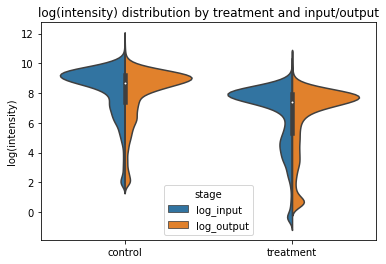

In [19]:
# Visually inspect the effect of censoring on distribution
tools.plot_input_output_violin(censored_data)

## Write data <a id="write"></a>

<div class="alert-warning">
<b>We write the censored, normalised, long-format data to the `datasets/` subdirectory.</b>
</div>

In [20]:
# Create output directory
outdir = 'datasets'
os.makedirs(outdir, exist_ok=True)

# Output files
full_dataset = os.path.join(outdir, "normalised_array_data.tab")  # all censored data
reduced_probe_dataset = os.path.join(outdir, "reduced_probe_data.tab")  # subset of data grouped by probe
reduced_locus_dataset = os.path.join(outdir, "reduced_locus_data.tab")  # subset of data grouped by locus tag

For modelling with Stan, we assign indexes for common probe ID, locus tag, and array (combination of replicate and treatment) to each probe, before writing out the complete dataset.

In [21]:
# Index on probes
indexed_data = tools.index_column(censored_data, 'probe')

# Index on locus tags
indexed_data = tools.index_column(indexed_data, 'locus_tag')

# Index on array (replicate X treatment)
indexed_data = tools.index_column(indexed_data, 'repXtrt')

# Uncomment the line below to inspect the data
#indexed_data.head(20)

In [22]:
# Write the full dataset to file
indexed_data.to_csv(full_dataset, sep="\t", index=False)

For testing, we want to create two data subsets, one containing a reduced number of probes, and one with a reduced number of genes/locus tags.

In [23]:
# Reduced probe set
reduced_probes = tools.reduce_dataset(indexed_data, 'probe')
reduced_probes.to_csv(reduced_probe_dataset, sep="\t", index=False)

In [24]:
# Reduced locus tag set
reduced_lts = tools.reduce_dataset(indexed_data, 'locus_tag')
reduced_lts.to_csv(reduced_locus_dataset, sep="\t", index=False)